In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import math
import random
import scipy

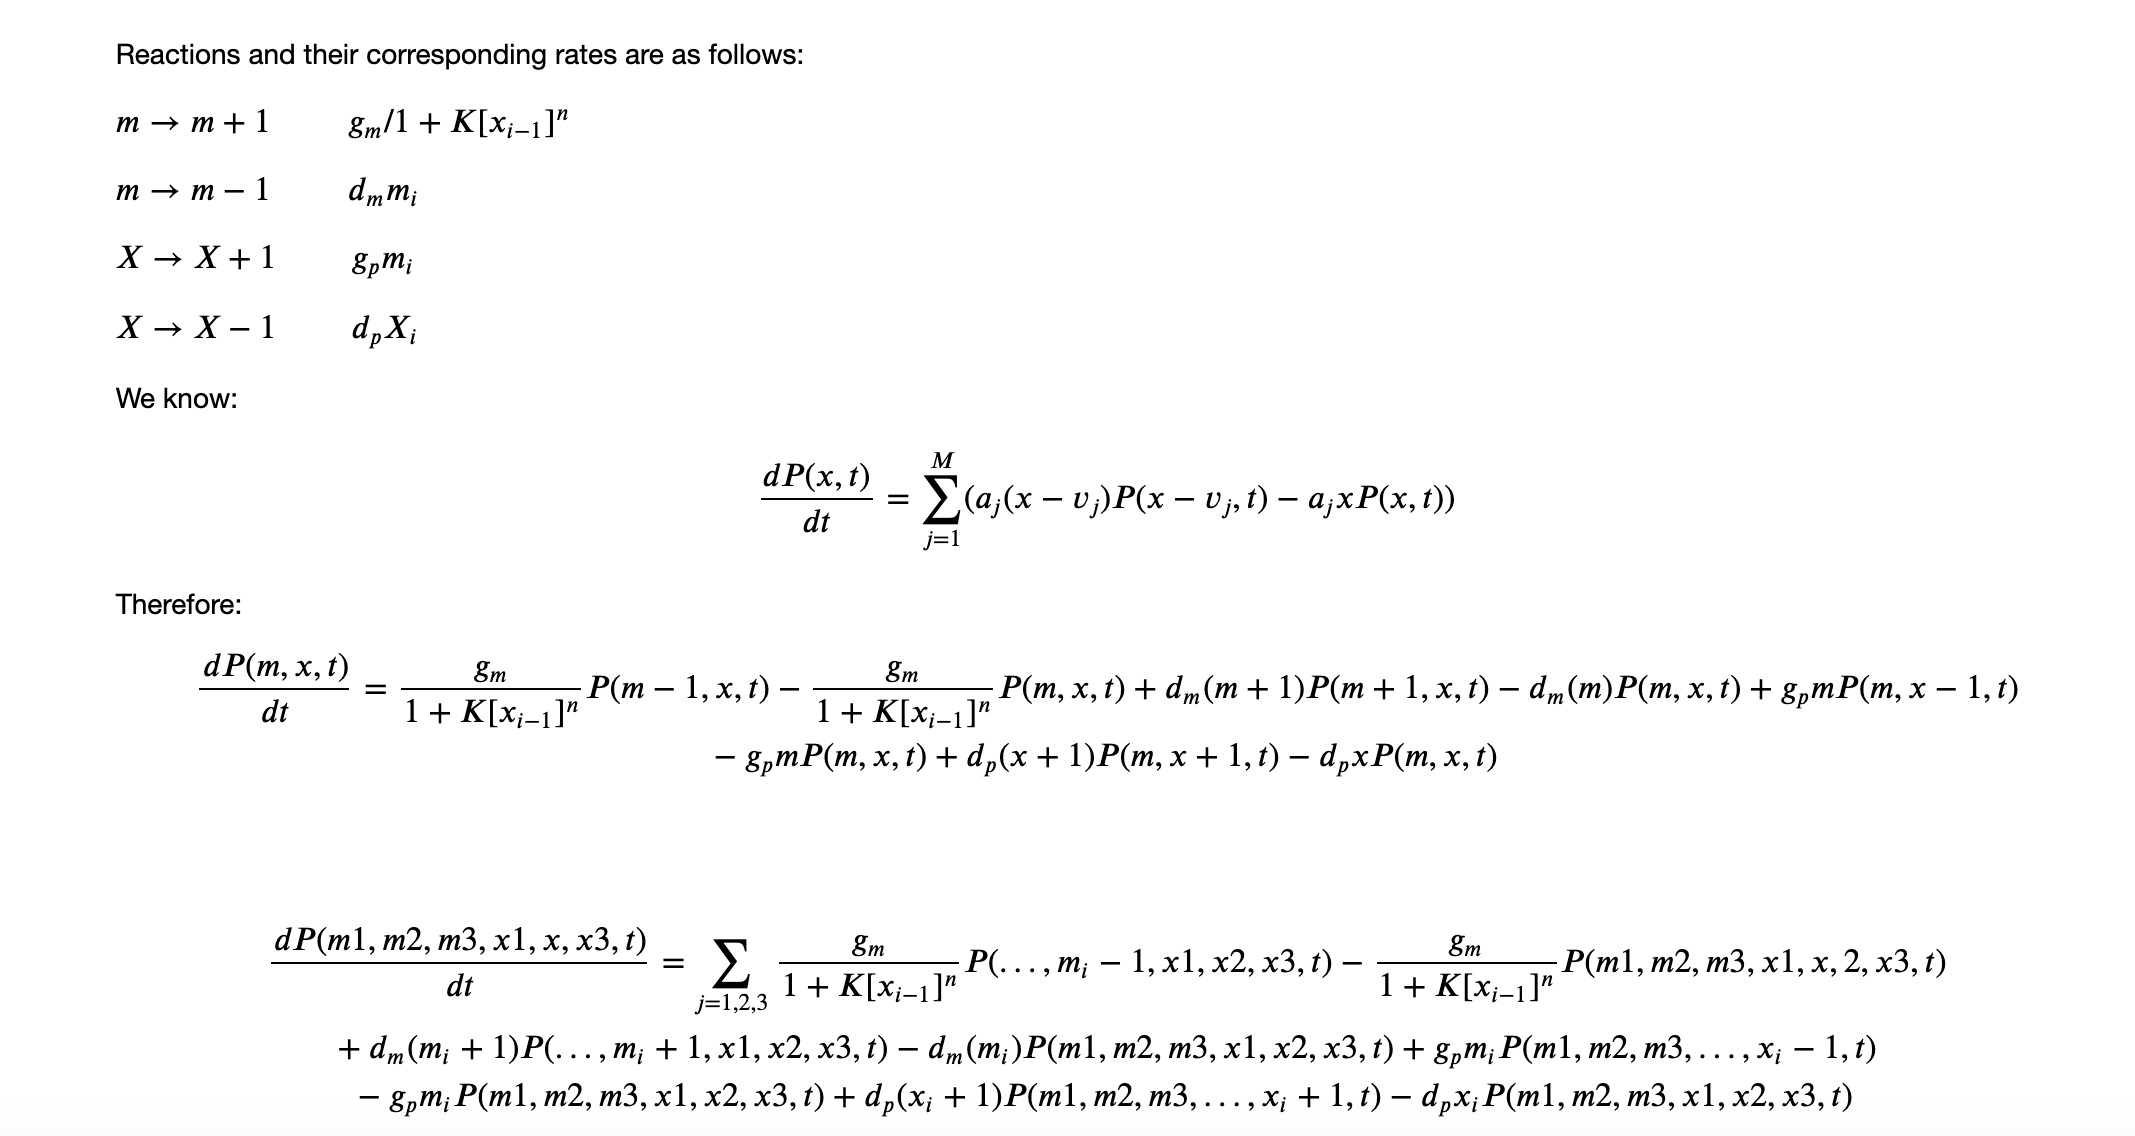

In [3]:
def Sim_func(size,maxtime,x):
    '''
    Performs SSA
    param:: size:
    param:: maxtime:
    param:: x: initial conditions for x=[m1,m2,m3,x1,x2,x3]
    return:: t,v
    '''    
    t = np.zeros(size)               #reaction times
    v = np.zeros((size, 6))          #molecular count 
    events = [(+1,0,0,0,0,0),(-1,0,0,0,0,0),(0,0,0,+1,0,0),(0,0,0,-1,0,0),(0,+1,0,0,0,0),(0,-1,0,0,0,0),
    (0,0,0,0,+1,0),(0,0,0,0,-1,0),(0,0,+1,0,0,0),(0,0,-1,0,0,0),(0,0,0,0,0,+1),(0,0,0,0,0,-1)]

    #no_events = np.arange(0,len(events),1)
    v[0] = np.zeros((size, 6))[0] + x
    ns = 0
    time = 0
    while time <= maxtime:       
        rates = np.array([gm/(1+k*v[(ns, 5)]**n),dm*v[(ns, 0)],gp*v[(ns, 0)],dp*v[(ns, 3)], 
                          gm/(1+k*v[(ns, 3)]**n),dm*v[(ns, 1)],gp*v[(ns, 1)],dp*v[(ns, 4)],
                          gm/(1+k*v[(ns, 4)]**n),dm*v[(ns, 2)],gp*v[(ns, 2)],dp*v[(ns, 5)]])     
        total_rate  =  sum(rates)
        dt = -math.log(1 - random.uniform(0.0, 1.0)) / total_rate 
        choose = np.random.choice(np.arange(len(events)), size=1, p=rates/total_rate)[0]
        v[ns+1] = v[ns]+ events[choose]
        t[ns+1]= t[ns]+dt
        ns = ns + 1
        time = time +dt
        if ns == size-1:
            break
    return t[0:ns], v[0:ns]

In [8]:
k = 1 #repression strength (affinity between TF and promoter)
dm = 1 #degradation rate fo mRNA
gm = 5 #Transcription rate of mRNA
dp = 10 #degradation rate of protein
gp = 10 #translation rate of protein
n = 1 #Hill coefficient constant
x=[10,10,10,10,10,10]     #x=[m1,m2,m3,x1,x2,x3] initial conditions
maxtime=100
t,v = Sim_func(10000,maxtime,x)

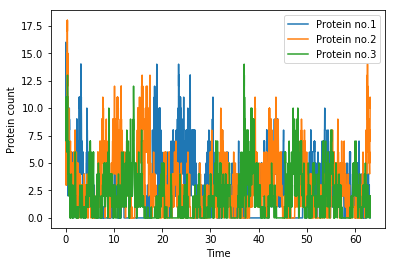

In [22]:
plt.plot(t,v[:,[3]])
plt.plot(t,v[:,[4]])
plt.plot(t,v[:,[5]])
plt.ylabel("Protein count")
plt.xlabel("Time")
plt.legend(['Protein no.1', 'Protein no.2', 'Protein no.3']);

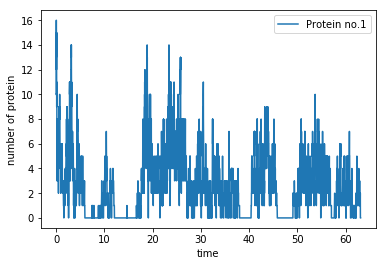

In [23]:
x1 = v[:,[3]].reshape(-1)
x2 = v[:,[4]].reshape(-1)
x3 = v[:,[5]].reshape(-1)
plt.plot(t,x1)
plt.ylabel("number of protein")
plt.xlabel("time")
plt.legend(['Protein no.1']);

In [107]:
def subsample(t_x,x,dt,N):
    '''Subsamples the SSA-generated trajectories
    param:: t_x: reaction times
    param:: x: molecule count
    param:: dt: subsampling interval length
    param:: N: maximum observation time 
    return:: y 
    '''
    L=int((N+1)*(1./dt))
    y=np.zeros(L)
    #print(L)
    y[0]=x[0]
    dummy=0
    index=1
    for k in range(1,len(t_x)):
        if t_x[k]>dummy: #& index<(L-2):
            #print(index)
            y[index]=x[k-1]
            dummy+=dt
            index+=1
    return y

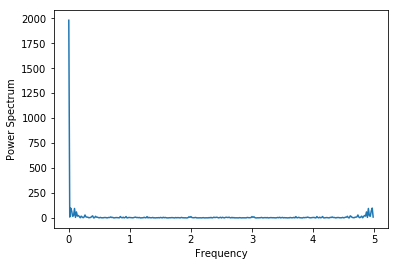

In [144]:
'''We take the FFT of the trajectory for protein 1 (subsampled every dt time unit), and obtain the Power spectrum so see
whether there are dominant frequencies that are present.'''
dt=0.2
x1_subsampled=subsample(t,x1,dt,int(np.round(max(t))))
x1_hat=scipy.fft(x1_subsampled)
PSD=x1_hat*np.conj(x1_hat)/len(x1_hat)
freq=(1/(dt*len(x1_subsampled)))*np.arange(len(x1_subsampled))
plt.plot(freq,np.real(PSD))
plt.xlabel('Frequency')
plt.ylabel('Power Spectrum')
plt.show()

The power spectrum reveals no dominant frequencies, and thus suggests that there is no oscillation in the data.

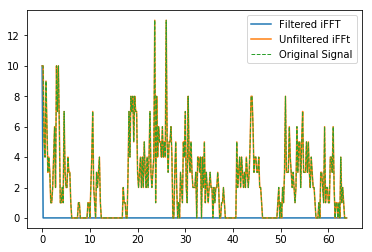

In [150]:
'''We filter the FFT to remove noise.'''
indices=PSD>100
x1_filtered=scipy.ifft(x1_hat)*indices
plt.plot(np.arange(0,int(len(y)*dt),dt),x1_filtered,label='Filtered iFFT')
plt.plot(np.arange(0,int(len(y)*dt),dt),scipy.ifft(x1_hat),label='Unfiltered iFFt')
plt.plot(np.arange(0,int(len(y)*dt),dt),x1_subsampled,linestyle='--',linewidth=1,label='Original Signal')
plt.legend()
plt.show()